In [83]:
import os
os.getcwd()

'/Users/mashazhuravlova/Desktop/Royal Flora Holland/very final data sets'

In [85]:
os.chdir("/Users/mashazhuravlova/Desktop/Royal Flora Holland/very final data sets")

In [4]:
import pandas as pd
final_df =pd.read_csv("final_df.csv",sep=",")

In [5]:
test_df =pd.read_csv("test_df.csv",sep=",")

In [6]:
train_df =pd.read_csv("train_df.csv",sep=",")

In [7]:
#We need an extremely simple baseline that requires minimal modeling assumptions. 
#We need it to show that our other “smarter” models add value. 
#The simplest prediction of trolleys in period t is the number of trolleys in previous period t-1.
#Trolleys today = Trolleys yesterday (lag1): Yt=Yt-1

In [8]:
#Define metrics: MAPE, MAE, RMSE.
#MAPE is calculated only on crop-type level because at the FPC level 
#volumes are often very small or zero, which makes percentage errors explode and 
#renders MAPE meaningless, while aggregation stabilizes the denominator and yields interpretable relative errors.

In [9]:
import numpy as np

def mape(y_true, y_pred):
    mask = (y_true != 0) & (~y_true.isna()) & (~y_pred.isna())
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
def mae(y_true, y_pred):
    mask = (~y_true.isna()) & (~y_pred.isna())
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))
def rmse(y_true, y_pred):
    mask = (~y_true.isna()) & (~y_pred.isna())
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [10]:
#fpc-level MAE.

In [11]:
final_df_fpc_mae_baseline = mae(
    final_df["trolleys"],
    final_df["trolleys_lag_1"]
)

print(f"[FPC] baseline MAE:  {final_df_fpc_mae_baseline:.2f}")

[FPC] baseline MAE:  69.26


In [12]:
#fpc-level RMSE.

In [20]:
final_df_fpc_rmse_baseline = rmse(
    final_df["trolleys"],
    final_df["trolleys_lag_1"]
)

print(f"[FPC] baseline RMSE: {final_df_fpc_rmse_baseline:.2f}")

[FPC] baseline RMSE: 162.85


In [22]:
#croptype-level MAPE.

In [24]:
final_df_crop_level = (
    final_df
    .groupby(["date", "logistieke location id", "crop_type"])
    .agg(
        trolleys_true=("trolleys", "sum"),
        trolleys_pred_lag_1=("trolleys_lag_1", "sum"),
    )
    .reset_index()
)

In [26]:
final_df_crop_mape_baseline = mape(
    final_df_crop_level["trolleys_true"],
    final_df_crop_level["trolleys_pred_lag_1"]
)

print(f"[CROP] baseline MAPE: {final_df_crop_mape_baseline:.2f}%")

[CROP] baseline MAPE: 25.99%


In [28]:
#croptype-level MAE.

In [30]:
final_df_crop_mae_baseline = mae(
    final_df_crop_level["trolleys_true"],
    final_df_crop_level["trolleys_pred_lag_1"]
)

print(f"[CROP] baseline MAE:  {final_df_crop_mae_baseline:.2f}")

[CROP] baseline MAE:  44333.01


In [32]:
#croptype-level RMSE.

In [34]:
final_df_crop_rmse_baseline = rmse(
    final_df_crop_level["trolleys_true"],
    final_df_crop_level["trolleys_pred_lag_1"]
)

print(f"[CROP] baseline RMSE: {final_df_crop_rmse_baseline:.2f}")

[CROP] baseline RMSE: 62814.91


In [38]:
print(f"[FPC] baseline MAE:  {final_df_fpc_mae_baseline:.2f}")
print(f"[FPC] baseline RMSE:  {final_df_fpc_rmse_baseline:.2f}")
print(f"[CROP] baseline MAPE: {final_df_crop_mape_baseline:.2f}%")
print(f"[CROP] baseline MAE:  {final_df_crop_mae_baseline:.2f}")
print(f"[CROP] baseline RMSE: {final_df_crop_rmse_baseline:.2f}")

[FPC] baseline MAE:  69.26
[FPC] baseline RMSE:  162.85
[CROP] baseline MAPE: 25.99%
[CROP] baseline MAE:  44333.01
[CROP] baseline RMSE: 62814.91


In [ ]:
#The lag-1 baseline performs reasonably at the FPC level, with a mean absolute error of 69 trolleys 
#and an RMSE of 163 trolleys, indicating moderate short-term volatility. 
#At the crop level, absolute error measures (MAE and RMSE) are substantially larger due to aggregation
#across many FPCs and therefore reflect scale rather than forecasting quality. 
#Consequently, relative performance is better assessed using MAPE, which equals 26% and indicates that, 
#on average, crop-level demand is forecast within roughly one quarter of actual volumes. 
#This highlights that while persistence captures overall demand dynamics, 
#the baseline struggles during high-volume periods, motivating more advanced models.

In [40]:
#Plot Actual vs Predicted values.

In [42]:
import matplotlib.pyplot as plt

def plot_pred_vs_actual(y_true, y_pred, title="Predicted vs Actual"):
    mask = (~y_true.isna()) & (~y_pred.isna())

    plt.figure(figsize=(6, 6))
    plt.scatter(y_true[mask], y_pred[mask], alpha=0.35)

    # 45-degree line (perfect prediction)
    min_val = min(y_true[mask].min(), y_pred[mask].min())
    max_val = max(y_true[mask].max(), y_pred[mask].max())
    plt.plot([min_val, max_val], [min_val, max_val])

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [44]:
#Actual vs Predicted values on FPC-level.

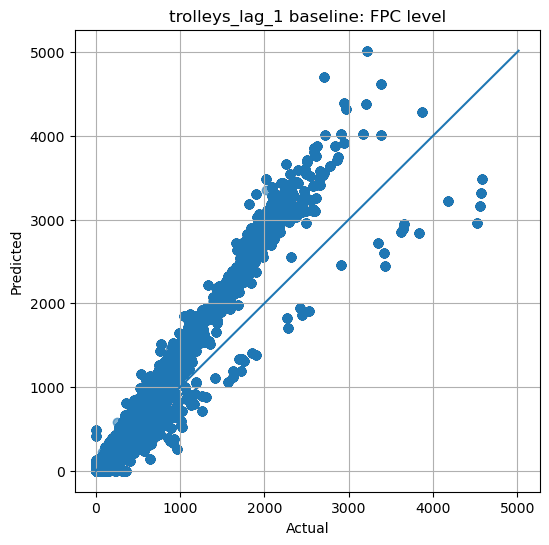

In [46]:
plot_pred_vs_actual(
    final_df["trolleys"],
    final_df["trolleys_lag_1"],
    title="trolleys_lag_1 baseline: FPC level"
)

In [48]:
#Actual vs Predicted values on crop type-level.

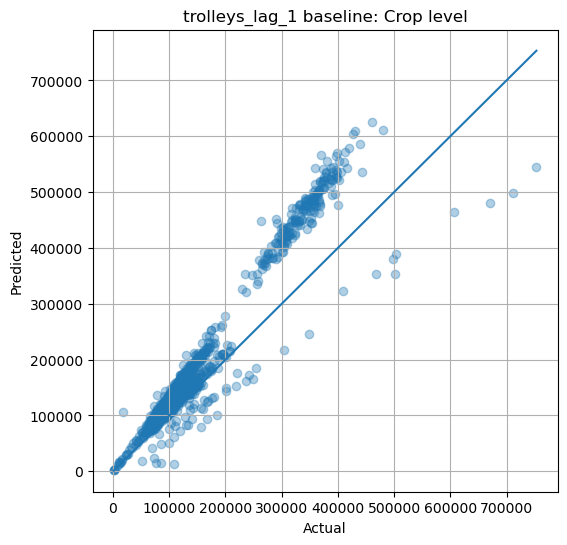

In [50]:
plot_pred_vs_actual(
    final_df_crop_level["trolleys_true"],
    final_df_crop_level["trolleys_pred_lag_1"],
    title="trolleys_lag_1 baseline: Crop level"
)

In [52]:
#Plot Actual vs Predicted values per location.

In [54]:
def plot_pred_vs_actual_per_location(
    df,
    location_col,
    y_true_col,
    y_pred_col,
    title_prefix="Predicted vs Actual"
):
    locations = df[location_col].dropna().unique()

    for loc in locations:
        df_loc = df[df[location_col] == loc]

        y_true = df_loc[y_true_col]
        y_pred = df_loc[y_pred_col]
        mask = (~y_true.isna()) & (~y_pred.isna())

        plt.figure(figsize=(6, 6))
        plt.scatter(y_true[mask], y_pred[mask], alpha=0.35)

        min_val = min(y_true[mask].min(), y_pred[mask].min())
        max_val = max(y_true[mask].max(), y_pred[mask].max())
        plt.plot([min_val, max_val], [min_val, max_val])

        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{title_prefix} – Location {loc}")
        plt.grid(True)
        plt.show()

In [56]:
#Actual vs Predicted values per location on fpc-level.

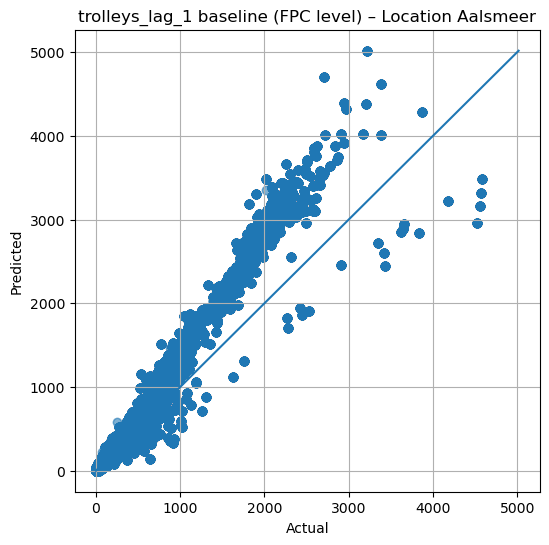

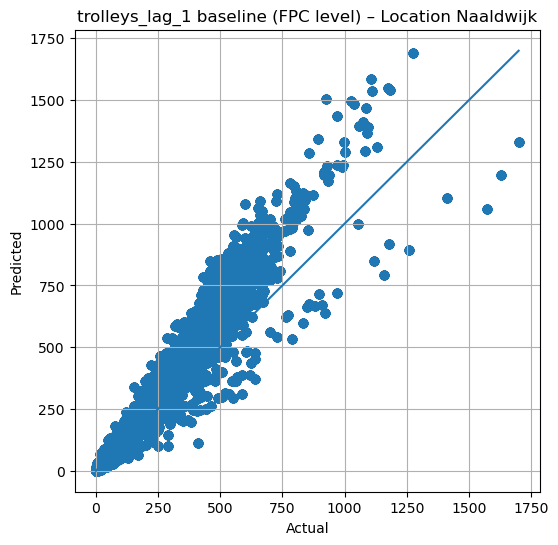

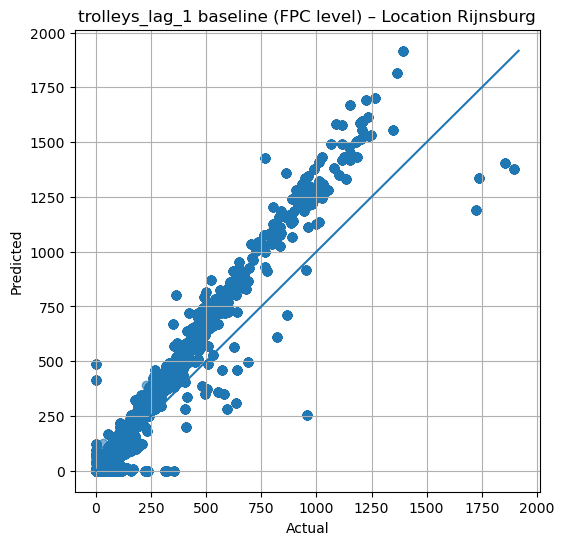

In [58]:
plot_pred_vs_actual_per_location(
    df=final_df,
    location_col="logistieke location id",
    y_true_col="trolleys",
    y_pred_col="trolleys_lag_1",
    title_prefix="trolleys_lag_1 baseline (FPC level)"
)

In [60]:
#Actual vs Predicted values per location on crop type-level.

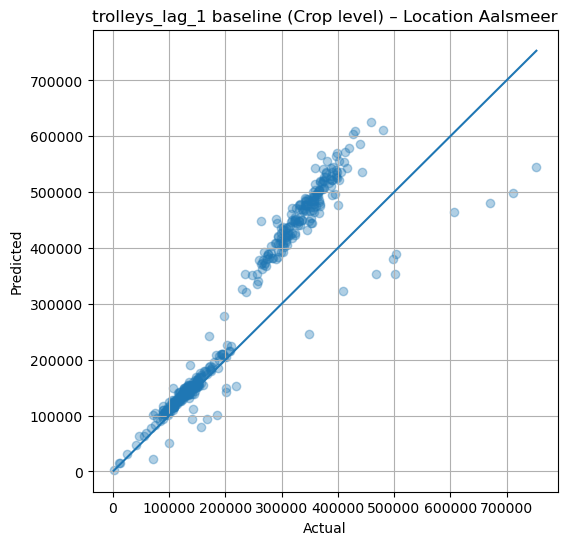

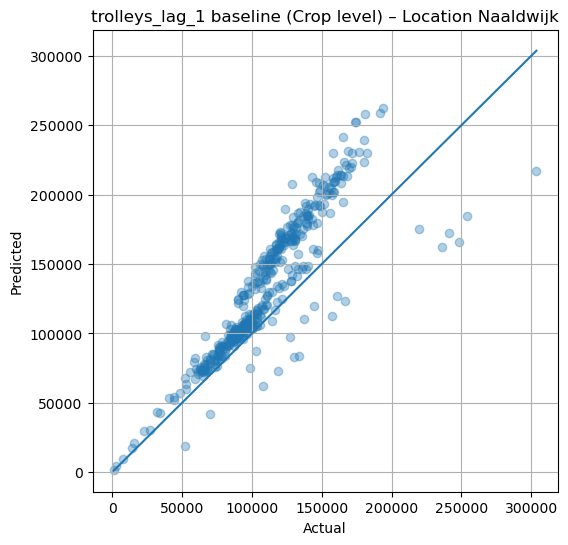

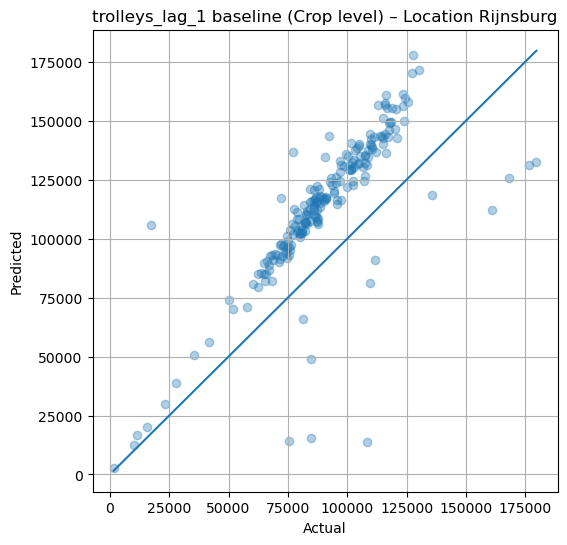

In [62]:
plot_pred_vs_actual_per_location(
    df=final_df_crop_level,
    location_col="logistieke location id",
    y_true_col="trolleys_true",
    y_pred_col="trolleys_pred_lag_1",
    title_prefix="trolleys_lag_1 baseline (Crop level)"
)

In [80]:
final_df_crop_level.head()

,date,logistieke location id,crop_type,trolleys_true,trolleys_pred_lag_1
0,2021-01-05,Aalsmeer,BL,263500,448200.0
1,2021-01-05,Aalsmeer,PL,98600,100500.0
2,2021-01-05,Naaldwijk,BL,128900,207500.0
3,2021-01-05,Naaldwijk,PL,73600,76150.0
4,2021-01-05,Rijnsburg,BL,72247,117145.0


In [64]:
#Plot Actual vs Predicted values per location and crop type per year.

In [72]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_ts_by_location_crop(
    df,
    date_col="date",
    location_col="logistieke location id",
    crop_col="crop_type",
    y_true_col="trolleys_true",
    y_pred_col="trolleys_pred_lag_1",   
    freq="W",                    # None = daily, "W" = weekly
    start=None,
    end=None
):
    df = df.copy()

    # 1) validate required columns
    required = [date_col, location_col, crop_col, y_true_col, y_pred_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in df: {missing}. Available columns: {list(df.columns)}")

    # 2) parse dates + optional window
    df[date_col] = pd.to_datetime(df[date_col])
    if start is not None:
        df = df[df[date_col] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df[date_col] <= pd.to_datetime(end)]

    # 3) loop over each (location, crop_type)
    combos = df[[location_col, crop_col]].dropna().drop_duplicates()

    for _, combo in combos.iterrows():
        loc = combo[location_col]
        crop = combo[crop_col]

        sub = df[(df[location_col] == loc) & (df[crop_col] == crop)].copy()
        sub = sub.dropna(subset=[y_true_col, y_pred_col]).sort_values(date_col)

        if sub.empty:
            continue

        # 4) optional aggregation (e.g. weekly sums)
        if freq is not None:
            sub = (sub.set_index(date_col)[[y_true_col, y_pred_col]]
                     .resample(freq).sum().reset_index())

        # 5) plot
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(sub[date_col], sub[y_true_col], label="Actual", linewidth=2)
        ax.plot(sub[date_col], sub[y_pred_col], label="Predicted", linewidth=2)

        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
        plt.xticks(rotation=45)

        ax.set_title(f"Location {loc} – {crop} ({'Weekly' if freq else 'Daily'})")
        ax.set_xlabel("Date")
        ax.set_ylabel("Trolleys")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

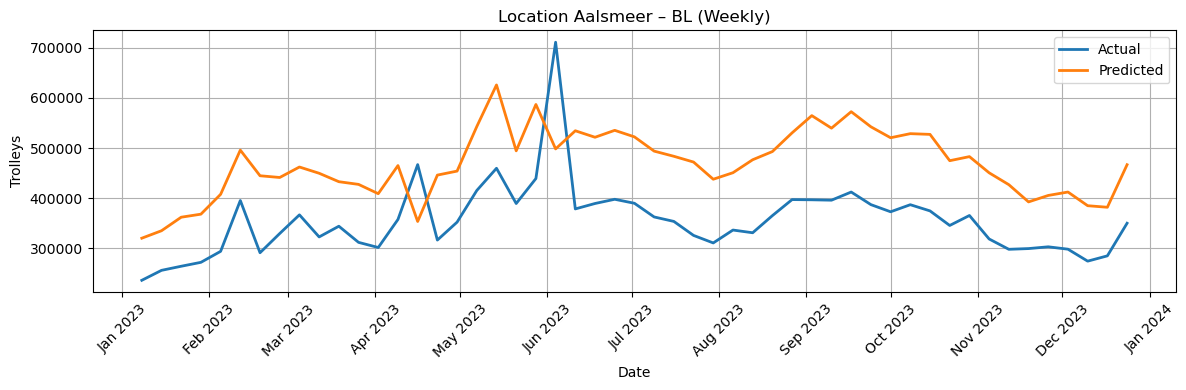

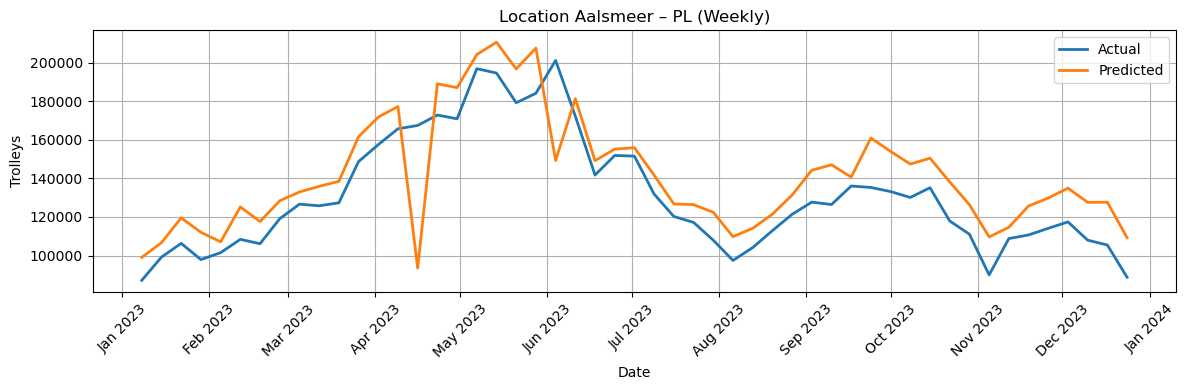

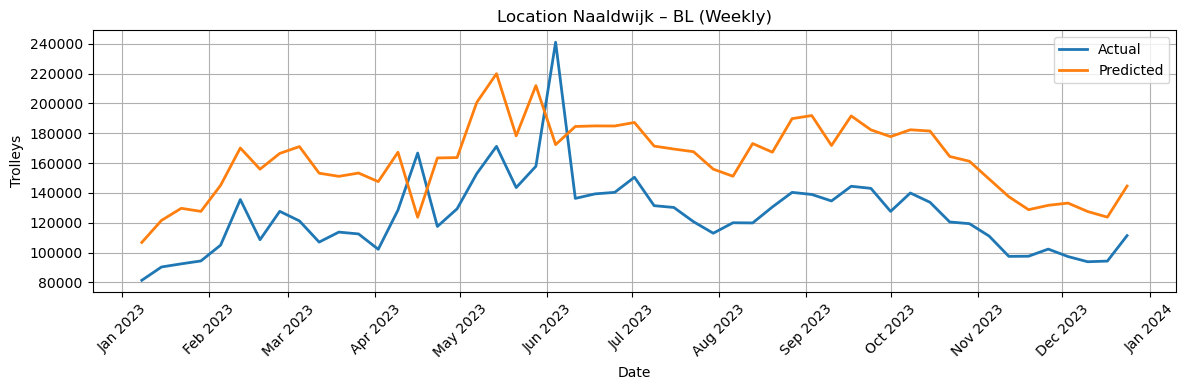

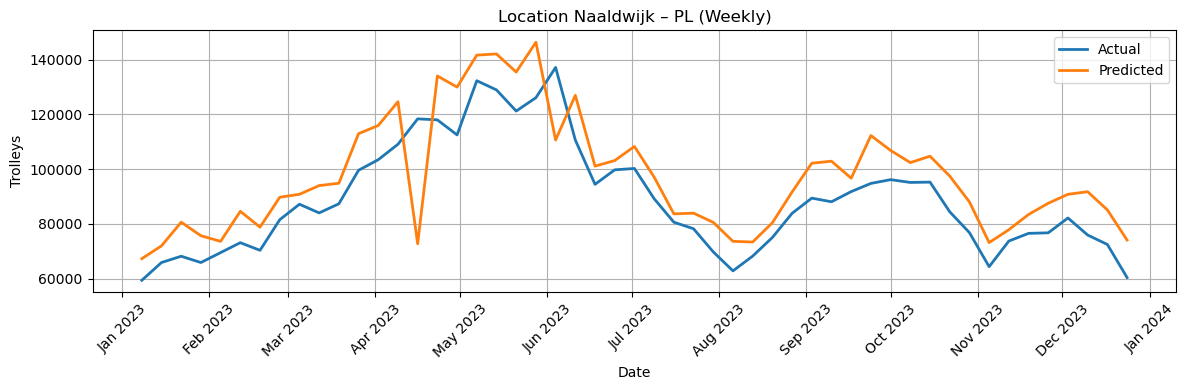

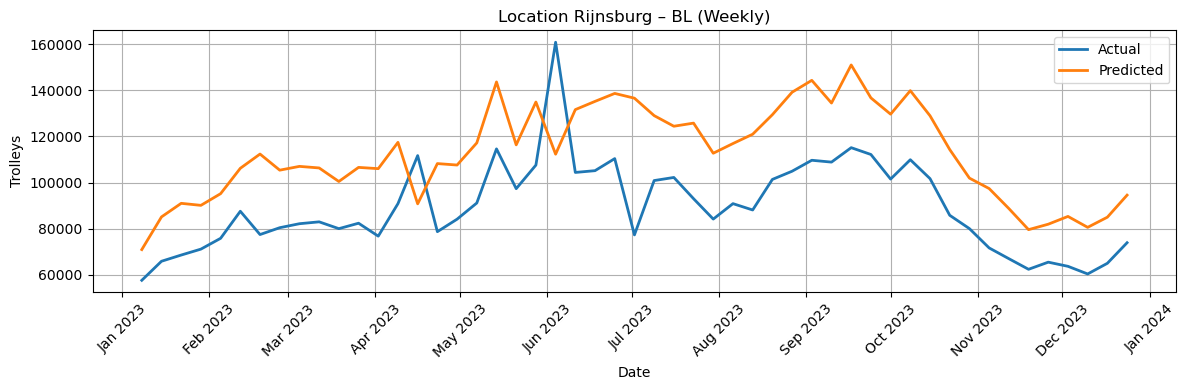

In [78]:
plot_ts_by_location_crop(
    final_df_crop_level,
    y_true_col="trolleys_true",
    y_pred_col="trolleys_pred_lag_1",  
    freq="W",
    start="2023-01-01",
    end="2023-12-31"
)